In [1]:
%reload_ext autoreload
%autoreload 2

import sys, os
sys.path.append("../")

import argparse
import numpy as np
import math
import pickle
from iotools.readOxford import ReadOxford
from iotools.readrpkm import ReadRPKM
from iotools.io_model import WriteModel
from inference.linreg_association import LinRegAssociation
from inference.empirical_bayes import EmpiricalBayes
from utils import hyperparameters
from inference import logmarglik
from iotools import readgtf
from utils import gtutils
from utils import mfunc
from utils.containers import ZstateInfo
from utils.printstamp import printStamp
from utils.helper_functions import write_params, load_target_genes
from sklearn.preprocessing import scale
from iotools import snp_annotator
import config_sbanerj as config

In [2]:
# Annotation (use complete gene name in gtf without trimming the version)
# load annotation for whole genome
gene_info = readgtf.gencode_v12(config.gtfpath, trim=False)

2018-07-06 18:05:49,249 | iotools.readgtf | INFO | Reading GTF file


In [3]:
# Load gene list
genelistfile = "genes4testing_high_and_low_r2_0.001"
# genelistfile = "genes4testing_highr2"
selected_gene_ids = load_target_genes(genelistfile, gene_info, config.chrom)
#print(selected_gene_ids)

Read 641 genes with high r2 values

Found 57 genes in CHR 12


In [4]:
if not os.path.exists(config.learn_pickfile_dev):
    # read Genotype
    oxf = ReadOxford(config.gtex_gtpath, config.gtex_samplepath, config.chrom, config.learning_dataset)
    genotype = np.array(oxf.dosage)
    samplenames = oxf.samplenames
    snps = oxf.snps_info

    printStamp("Dumping CHR {:d} genotype".format(config.chrom))
    with open(config.learn_pickfile_dev, 'wb') as output:
        pickle.dump(oxf, output, pickle.HIGHEST_PROTOCOL)
else:
    printStamp("Reading pickled genotype")
    with open(config.learn_pickfile_dev, 'rb') as input:
        pickled_oxf = pickle.load(input)

    printStamp("Done reading")

    genotype = np.array(pickled_oxf.dosage)
    samplenames = pickled_oxf.samplenames
    snps = pickled_oxf.snps_info
    nsample = len(pickled_oxf.samplenames)

# Quality control
f_snps, f_genotype = gtutils.remove_low_maf(snps, genotype, 0.1)
gt = gtutils.normalize(f_snps, f_genotype)

# Gene Expression
rpkm = ReadRPKM(config.gtex_rpkmpath, "gtex")
expression = rpkm.expression
expr_donors = rpkm.donor_ids
gene_names = rpkm.gene_names

# Selection
printStamp("Selection of samples")
vcfmask, exprmask = mfunc.select_donors(samplenames, expr_donors)
genes, indices = mfunc.select_genes(gene_info, gene_names)

gene_training_list = []
for i, gene in enumerate(genes):
    k = indices[i]
    if gene.ensembl_id in selected_gene_ids and gene.chrom == config.chrom:
        gene_training_list.append((k,gene))
        # print(k,gene)

2018-07-06 18:06:05 - Reading pickled genotype
2018-07-06 18:06:08 - Done reading
2018-07-06 18:06:13 - Selection of samples


In [5]:

p = config.parameters[0]

prior = p[0]
params = p[1]
hyperpriors = []
hyperparams = p[3]
run_description = p[4]
cutoff = p[5]
usedist = p[6]
usefeat = p[7]

print(p)


['gxpred-pointnormal', [0.001, 0.0, 0.5, 0.0, 0.8], [None, None, None, None, None], None, 'pointnormal', 'soft', 'nodist', 'nofeat']


In [6]:
from iotools import snp_annotator
from collections import defaultdict
import gzip 

model_dir = "{:s}_{:s}_{:s}_{:s}_{:.3f}_{:.3f}_{:.3f}_{:.3f}_{:.3f}".format(prior, cutoff, usedist, usefeat, params[0], params[1], params[2], params[3], params[4])
outdir = "."
modelpath = os.path.join(outdir, "z"+str(config.zmax), config.run_description, model_dir)

print(modelpath)

write_params(modelpath, p)

model = WriteModel(modelpath, config.chrom)

# Load rsid dictionary
annot_dict = defaultdict(list)
if usefeat == "1kg":
    annotfile = os.path.join(config.annot1kg_dir, "1KG."+str(config.chrom)+".annot.gz")
    print(annotfile)
    with gzip.open(annotfile, 'r') as instream:
        _ = instream.readline()
        for line in instream:
            arr = line.decode().strip().split(" ")
            rsid = arr[0]
            annots = list(map(int, arr[1:]))
            annot_dict[rsid] = annots


#for i in range(len(gene_training_list)):
for i in range(50, 57):

    k, gene = gene_training_list[i]

    print(k, gene)

    printStamp("Learning for gene "+str(gene.ensembl_id))

    # select only the cis-SNPs
    cismask = mfunc.select_snps(gene, f_snps, config.window)
    if len(cismask) > 0:
        target = expression[k, exprmask]
        target = scale(target, with_mean=True, with_std=True)
        predictor = gt[cismask][:, vcfmask]
        snpmask = cismask

        # if number of cis SNPs > threshold, use p-value cut-off

        min_pos = f_snps[cismask[0]].bp_pos - 1000
        max_pos = f_snps[cismask[-1]].bp_pos + 1000
        
        if len(cismask) > config.min_snps:
            assoc_model = LinRegAssociation(predictor, target, config.min_snps, config.pval_cutoff, cutoff)
            pvalmask = cismask[assoc_model.selected_variables]
            if pvalmask.shape[0] == 0:
                print("No significant SNPs found for gene {:s}".format(gene.ensembl_id))
                continue
            print ("Found {:d} SNPs, reduced to {:d} SNPs (max p-value {:g}) for {:s}".format(len(cismask), len(pvalmask), assoc_model.ordered_pvals[len(pvalmask) - 1], gene.name))
            predictor = gt[pvalmask][:, vcfmask]
            snpmask = pvalmask
        else:
            print ("Found {:d} SNPs for {:s}".format(len(cismask), gene.name))

        if config.shuffle_geno:
            print("Shuffling Genotype!")
            np.random.shuffle(predictor.T)

        selected_snps = [f_snps[x] for x in snpmask]

        if config.prune_LD:
            ld_indices = snp_annotator.get_snps_LD(gene, selected_snps, min_pos, max_pos, config.genofile_plink, config.ldstorepath, config.ld_path)
            snpmask = np.delete(snpmask, np.reshape(ld_indices, -1))
            predictor = gt[snpmask][:, vcfmask]

            # replace with the pruned snsp in LD
            selected_snps = [f_snps[x] for x in snpmask]

            print ("Reduced to {:d} SNPs".format(len(snpmask)))
        
        # read the features
        # TODO: only returns the base feature (vect of 1's)
        feature0 = np.ones((len(selected_snps), 1))
        
        if usefeat == "1kg":
            current_annot = list()
            for snp in selected_snps:
                if len(annot_dict[snp.varid]) > 0:
                    current_annot.append(annot_dict[snp.varid])
                else:
                    current_annot.append([0,0,0,0,0])
                    print("not found {:s}!".format(snp.varid))
            feature1kg = np.array(current_annot)
        
            features = np.concatenate((feature0, feature1kg), axis=1)
        else:
            features = feature0
                    
        # add UTR feature
#         utr_feature = snp_annotator.get_GENCODE_annotation(config.gtfpath, gene, selected_snps, "UTR")
#         exon_feature = snp_annotator.get_GENCODE_annotation(config.gtfpath, gene, selected_snps, "exon")
#         features = np.concatenate((feature0, utr_feature, exon_feature), axis=1)

        # Get DHS distance feature
        dist_feature = snp_annotator.get_distance_feature(selected_snps, gene, usedist)

        nfeat = features.shape[1]
        print("Loaded {:d} features".format(nfeat))

        init_params = np.zeros(nfeat + 4)
        init_params[0] = - np.log((1 / params[0]) - 1)
        if nfeat > 1:
            for i in range(1, nfeat):
                init_params[i] = - np.log((1 / params[0]) - 1)
        init_params[nfeat + 0] = params[1] # mu
        init_params[nfeat + 1] = params[2] # sigma
        init_params[nfeat + 2] = params[3] # sigmabg
        init_params[nfeat + 3] = 1 / params[4] / params[4] # tau

        # perform the analysis

        print ("Starting first optimization ==============")
        emp_bayes = EmpiricalBayes(predictor, target, features, dist_feature, 1, init_params, method="new")
        emp_bayes.fit()
        if config.zmax > 1:
            if emp_bayes.success:
                res = emp_bayes.params
                print ("Starting second optimization from previous results ================")
                # Python Error: C library could not compute z-components. Check C errors above.
            else:
                res = init_params
                print ("Starting second optimization from initial parameters ================")
            emp_bayes = EmpiricalBayes(predictor, target, features, dist_feature, config.zmax, res, method="new")
            emp_bayes.fit()

        if emp_bayes.success:
            res = emp_bayes.params
            res[4] = 1 / np.sqrt(res[4])

            print(res)
#             print("PI: \t",res[0])
#             print("mu: \t",res[1])
#             print("sigma: \t",res[2])
#             print("sigmabg: \t",res[3])
#             print("tau: \t",res[4])

            model_snps = [f_snps[x] for x in snpmask]
            model_zstates = list()
            scaledparams = hyperparameters.scale(emp_bayes.params)
            zprob, zexp = logmarglik.model_exp(scaledparams, predictor, target, features, dist_feature, emp_bayes.zstates)
            for j, z in enumerate(emp_bayes.zstates):
                this_zstate = ZstateInfo(state = z,
                                         prob  = zprob[j],
                                         exp   = list(zexp[j, :]) )
                model_zstates.append(this_zstate)
            # print(model_snps)
            # for i,m in enumerate(model_zstates):
            #     print("z-state: ",i," Prob:", m.prob)
            model.write_success_gene(gene, model_snps, model_zstates, res)
        else:
            model.write_failed_gene(gene, np.zeros_like(init_params))
            print ("Failed optimization")

./z1/pointnormal/gxpred-pointnormal_soft_nodist_nofeat_0.001_0.000_0.500_0.000_0.800
14851 GeneInfo(name='MLEC', ensembl_id='ENSG00000110917.3', chrom=12, start=121124671, end=121139667)
2018-07-06 18:06:37 - Learning for gene ENSG00000110917.3
Found 2581 SNPs, reduced to 200 SNPs (max p-value 0.0236668) for MLEC
Loaded 1 features
Starting first optimization ==============
      fun: 477.86616855933704
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.94900453e-05,   3.45827942e-02,   3.27921378e-05,
        -0.00000000e+00,   5.15771050e-04])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 22
      nit: 18
   status: 0
  success: True
        x: array([-5.36116056,  0.        , -1.80654528,  0.        , -0.01287864])
[-5.36116056  0.          0.16422049  0.          0.98720394]
14869 GeneInfo(name='ORAI1', ensembl_id='ENSG00000182500.7', chrom=12, start=122064454, end=122080583)
2018-07-06 18:06:51 - Learning for gene ENSG0000018250

# Prediction

In [7]:
import sys
sys.path.append("../")
import os
import pickle
from utils.printstamp import printStamp
from iotools.io_model import ReadModel
from iotools.readOxford import ReadOxford
from utils.containers import GeneExpressionArray
from utils import gtutils
from utils import mfunc
import numpy as np
import config_sbanerj as config

In [8]:
if not os.path.exists(config.p_pickfile_dev):
# Read genotype (quite slow for testing) use pickle below
    p_oxf = ReadOxford(config.p_gtpath, config.p_samplepath, config.chrom, config.predicting_dataset)
    p_genotype = np.array(p_oxf.dosage)
    p_samplenames = p_oxf.samplenames
    p_snps = p_oxf.snps_info
    p_nsample = len(p_oxf.samplenames)

    printStamp("Dumping CHR {:d} genotype".format(chrom))
    with open(config.p_pickfile_dev, 'wb') as output:
        pickle.dump(p_oxf, output, pickle.HIGHEST_PROTOCOL)
else:
    printStamp("Reading pickled genotype")
    with open(config.p_pickfile_dev, 'rb') as input:
        pickled_oxf = pickle.load(input)

    printStamp("Done reading")

    p_genotype = np.array(pickled_oxf.dosage)
    p_samplenames = pickled_oxf.samplenames
    p_snps = pickled_oxf.snps_info
    p_nsample = len(pickled_oxf.samplenames)


2018-07-06 18:08:16 - Reading pickled genotype
2018-07-06 18:08:22 - Done reading


In [9]:
p = config.parameters[0]

prior = p[0]
params = p[1]
hyperpriors = []
hyperparams = p[3]
run_description = p[4]
cutoff = p[5]
usedist = p[6]
usefeat = p[7]

print(p)


model_dir = "{:s}_{:s}_{:s}_{:s}_{:.3f}_{:.3f}_{:.3f}_{:.3f}_{:.3f}".format(prior, cutoff, usedist, usefeat, params[0], params[1], params[2], params[3], params[4])
outdir = "."
modelpath = os.path.join(outdir, "z"+str(config.zmax), config.run_description, model_dir)

['gxpred-pointnormal', [0.001, 0.0, 0.5, 0.0, 0.8], [None, None, None, None, None], None, 'pointnormal', 'soft', 'nodist', 'nofeat']


In [10]:
outfileprefix = os.path.join(modelpath,"pred_chr"+str(config.chrom))

printStamp("Predicting for "+modelpath)
# Write predictions for each model
p_model = ReadModel(modelpath, config.chrom)
p_genes = p_model.genes
gx = list()
for gene in p_genes:

    p_model.read_gene(gene)
    p_model_snps = p_model.snps
    p_model_zstates = p_model.zstates

    x = gtutils.prediction_variables(p_snps, p_model_snps, p_genotype)
    x = gtutils.normalize(p_model_snps, x)

    ypred = np.zeros(p_nsample)
    for z in p_model_zstates:
        ypred += z.prob * np.dot(x.T, z.exp)

    gx.append(GeneExpressionArray(geneid = gene.ensembl_id, expr_arr = ypred))


# Write output
printStamp("Done predicting for "+modelpath)
mfunc.write_gcta_phenotype(outfileprefix, p_samplenames, gx)

2018-07-06 18:08:24 - Predicting for ./z1/pointnormal/gxpred-pointnormal_soft_nodist_nofeat_0.001_0.000_0.500_0.000_0.800
2018-07-06 18:09:07 - Done predicting for ./z1/pointnormal/gxpred-pointnormal_soft_nodist_nofeat_0.001_0.000_0.500_0.000_0.800


# Assessment 

In [11]:
import sys
sys.path.append("../")
import os
from iotools import readgtf
from iotools.readrpkm import ReadRPKM
from iotools.readPrediction import ReadPrediction
from scipy.stats import pearsonr
from utils.helper_functions import write_r2_dataframe, get_common_elements, pearson_corr_rowwise
import math
import pickle
from utils.printstamp import printStamp

import config_sbanerj as config

In [12]:

# Load reference dataset Gene Expression
reference_rpkm = ReadRPKM(config.reference_expdatapath, config.predicting_dataset)
reference_expression = reference_rpkm.expression
reference_expr_donors = reference_rpkm.donor_ids
reference_gene_names = reference_rpkm.gene_names

In [13]:
# use the selected_gene_ids with high R² values as targets, only those in the selected chrom will appear
# genelistfile = "genes4testing_highr2"
genelistfile = "genes4testing_high_and_low_r2_0.001"
selected_gene_ids = load_target_genes(genelistfile, gene_info, config.chrom)
target_genelist = [g.split(".")[0] for g in selected_gene_ids]
target_donors = reference_expr_donors


Read 641 genes with high r2 values

Found 57 genes in CHR 12


In [14]:
### Predixcan assessment ###

if not os.path.exists(config.predixcan_pickfile_dev):
    predixcanpred = ReadPrediction(config.pxpred_predpath, config.reference_samplepath, "predixcan", trim=True)

    if len(predixcanpred.gene_names) > 0:
        printStamp("Dumping Predixcan prediction")
        with open(config.predixcan_pickfile_dev, 'wb') as output:
            pickle.dump(predixcanpred, output, pickle.HIGHEST_PROTOCOL)
    else:
        raise("No prediction data found")
else:
    printStamp("Reading pickled Predixcan prediction")
    with open(config.predixcan_pickfile_dev, 'rb') as input:
        predixcanpred = pickle.load(input)

# filter predixcan predictions with only those in gxpred
predixcanpred.sort_by_gene(target_genelist)
predixcanpred.sort_by_samples(target_donors, use_prev=True)

sorted_expr_donors, ix_samples = get_common_elements(reference_expr_donors, predixcanpred.sorted_samples)
sorted_gene_names, ix_genes = get_common_elements(reference_gene_names, predixcanpred.sorted_gene_names)
sorted_expression = reference_expression[ix_genes,:][:, ix_samples].T

predixcan_r = pearson_corr_rowwise(predixcanpred.sorted_expr_mat.T, sorted_expression.T)



2018-07-06 18:09:13 - Reading pickled Predixcan prediction
Genes found: 46 of 57
Samples found: 744 of 849
(786, 46)


In [15]:
%load_ext autoreload
%autoreload 2

### GXpred assessment ###

print(modelpath)

gxpred_predpath = os.path.join(modelpath)
gxpred = ReadPrediction(gxpred_predpath, config.reference_samplepath, "gxpred", trim=True)

# filter gxpred predicted values
gxpred.sort_by_gene(target_genelist)
gxpred.sort_by_samples(target_donors, use_prev=True)


# Filter and sort the reference expression values
# Cardiogenics variables
# expression
# expr_donors
# gene_names

sorted_expr_donors, ix_samples = get_common_elements(reference_expr_donors, gxpred.sorted_samples)
sorted_gene_names, ix_genes = get_common_elements(reference_gene_names, gxpred.sorted_gene_names)
sorted_expression = reference_expression[ix_genes,:][:, ix_samples].T

# Calculate Pearson correlation
gxpred_r = pearson_corr_rowwise(gxpred.sorted_expr_mat.T, sorted_expression.T)

print(gxpred.sorted_gene_names)
print(gxpred_r**2)
print(predixcan_r**2)


# Write to table with predictions for given genes
# predtabledir = os.path.join(home, "gxpred","devtools", "all_predictions.txt")
# new_write_predicted_r2(predtabledir, prior, params, gxpred_r, predixcan_r, gxpred.sorted_gene_names)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
./z1/pointnormal/gxpred-pointnormal_soft_nodist_nofeat_0.001_0.000_0.500_0.000_0.800
No prediction found for CHR 1
No prediction found for CHR 2
No prediction found for CHR 3
No prediction found for CHR 4
No prediction found for CHR 5
No prediction found for CHR 6
No prediction found for CHR 7
No prediction found for CHR 8
No prediction found for CHR 9
No prediction found for CHR 10
No prediction found for CHR 11
Loaded 7 genes in CHR 12
No prediction found for CHR 13
No prediction found for CHR 14
No prediction found for CHR 15
No prediction found for CHR 16
No prediction found for CHR 17
No prediction found for CHR 18
No prediction found for CHR 19
No prediction found for CHR 20
No prediction found for CHR 21
No prediction found for CHR 22
Genes found: 7 of 57
Samples found: 744 of 849
(786, 7)
['ENSG00000110917', 'ENSG00000182500', 'ENSG00000183955', 'ENSG00000139370', 'ENSG00000151948', 'ENSG000

In [16]:
write_r2_dataframe(modelpath, config.chrom, "predixcan", predixcan_r, predixcanpred, overwrite=True)
write_r2_dataframe(modelpath, config.chrom, "gxpred-ptnormal", gxpred_r, gxpred)

In [17]:
import pandas as pd
r2table = os.path.join(modelpath, "genes_r2_{:s}.txt".format(str(config.chrom)))
df = pd.read_table(r2table, header=0)

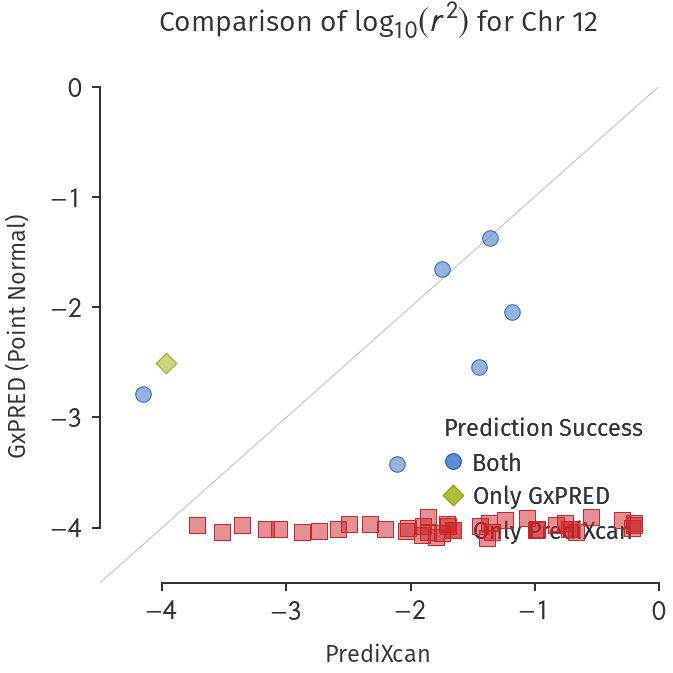

In [18]:
%reload_ext autoreload
%autoreload 2

import fancy_plot
import pandas as pd
import matplotlib.pyplot as plt

icol = 'predixcan'
jcol = 'gxpred-ptnormal'
xlabel = 'PrediXcan'
ylabel = 'GxPRED (Point Normal)'
inanlegend = 'Only GxPRED'
jnanlegend = 'Only PrediXcan'
r2plot_pdf  = os.path.join(modelpath, "genes_r2_{:s}_{:s}_{:s}.pdf".format(str(config.chrom), icol, jcol))
r2plot_png  = os.path.join(modelpath, "genes_r2_{:s}_{:s}_{:s}.png".format(str(config.chrom), icol, jcol))

fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111)
fancy_plot.draw(df, icol, jcol, ax, xlabel, ylabel, inanlegend, jnanlegend,
                titletext = r'Comparison of $\log_{10}(r^2)$ for Chr 12',
                showfill = 0.0)
plt.tight_layout()
plt.savefig(r2plot_pdf)
plt.savefig(r2plot_png)
plt.show()

In [19]:
df

,Ensembl_ID,Gene_Name,Success,Mu,Sigma,Sigma_bg,Sigma_tau,Gamma0,predixcan,gxpred-ptnormal
0,ENSG00000110917,MLEC,True,0.0,0.16422,0.0,0.98720,-5.36116,0.03540,0.00283
1,ENSG00000182500,ORAI1,True,0.0,0.49849,0.0,0.96729,-6.90335,0.04350,0.04253
2,ENSG00000183955,SETD8,True,0.0,0.22880,0.0,0.97081,-5.74374,0.00773,0.00038
3,ENSG00000139370,SLC15A4,True,0.0,0.16033,0.0,0.98849,-5.42170,NaN,0.00309
4,ENSG00000151948,GLT1D1,True,0.0,0.22674,0.0,0.97491,-5.30788,0.00007,0.00162
5,ENSG00000111450,STX2,True,0.0,0.62617,0.0,0.77005,-5.62400,0.01794,0.02192
6,ENSG00000184967,NOC4L,True,0.0,0.16085,0.0,0.98994,-5.49606,0.06623,0.00908
7,ENSG00000151065,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00030,NaN
8,ENSG00000078237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00087,NaN
9,ENSG00000139194,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00044,NaN
